In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import random
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [22]:
#Read dataset
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

#add location to each sample
train_a["location"] = "A"
train_b["location"] = "B"
train_c["location"] = "C"
X_train_estimated_a["location"] = "A"
X_train_estimated_b["location"] = "B"
X_train_estimated_c["location"] = "C"
X_train_observed_a["location"] = "A"
X_train_observed_b["location"] = "B"
X_train_observed_c["location"] = "C"

#remove extra minute 00 sample
X_train_observed_a = X_train_observed_a.iloc[:-1,:]
X_train_observed_b = X_train_observed_b.iloc[:-1,:]
X_train_observed_c = X_train_observed_c.iloc[:-1,:]

#add date_calc column same as date_forecast column to observed data
X_train_observed_a.insert(0, "date_calc", X_train_observed_a["date_forecast"])
X_train_observed_b.insert(0, "date_calc", X_train_observed_b["date_forecast"])
X_train_observed_c.insert(0, "date_calc", X_train_observed_c["date_forecast"])

#concat all the samples and remove date_calc column
X_train_raw = pd.concat([X_train_observed_a,
                     X_train_observed_b,
                     X_train_observed_c,
                     X_train_estimated_a,
                     X_train_estimated_b,
                     X_train_estimated_c])

#remove some weird artifacts from train_b target values
train_b = pd.concat([train_b[:18690], train_b[20142:]])
train_b["rolling"] = train_b["pv_measurement"].rolling(4).mean()
train_b["keep"] = train_b["pv_measurement"] - train_b["rolling"] != 0 + train_b["pv_measurement"].apply(lambda a: a==0)
train_b = train_b[train_b["keep"]]
train_b = train_b.iloc[:,:3]

targets = pd.concat([train_a,
                     train_b,
                     train_c]).dropna()

#X_train_raw["date_forecast"] = X_train_raw["date_forecast"] + pd.Timedelta(minutes=-60)

features00 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 0)].copy()
features00["merge_time"] = features00["date_forecast"]


features15 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 15)].copy()
features15["merge_time"] = features15["date_forecast"] + pd.Timedelta(minutes=-15)


features30 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 30)].copy()
features30["merge_time"] = features30["date_forecast"] + pd.Timedelta(minutes=-30)


features45 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 45)].copy()
features45["merge_time"] = features45["date_forecast"] + pd.Timedelta(minutes=-45)


X_train_raw["date_forecast"] = X_train_raw["date_forecast"] + pd.Timedelta(minutes = -60)
features60 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 00)].copy()
features60["merge_time"] = features60["date_forecast"]

dataset = targets
dataset = dataset.rename(columns={"time": "merge_time"})

#averages the features meassured at target time +00, +15, +30, +45 and +60
def add_feature_average_00_60(dataset, f00, f15, f30, f45, f60, column_name):
    dataset = pd.merge(
        left=dataset,
        right = f00[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner")
    dataset = pd.merge(
        left=dataset,
        right = f15[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_15"])
    dataset = pd.merge(
        left=dataset,
        right = f30[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_30"])
    dataset = pd.merge(
        left=dataset,
        right = f45[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_45"])
    dataset = pd.merge(
        left=dataset,
        right = f60[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_60"])


    dataset[column_name] = (dataset[column_name] +
                            dataset[column_name + "_15"] +
                            dataset[column_name + "_30"] +
                            dataset[column_name + "_45"] +
                            dataset[column_name + "_60"])/5
    dataset = dataset.drop([column_name + "_15",
                            column_name + "_30",
                            column_name + "_45",
                            column_name + "_60"],
                           axis=1)

    return dataset

#adds a single feature from one observation
def add_feature(dataset, f, column_name):
  return pd.merge(
        left=dataset,
        right=f[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner"
  )

#adds an One Hot Encoding of the column to the dataset
def OHE(dataset, f, column_name, suffix=""):

    dataset = pd.merge(
        left=dataset,
        right = f[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner")

    values = dataset[column_name].unique()

    for value in values:
        dataset[column_name + "_" + suffix + str(value)] = dataset[column_name].apply(lambda a : a == value).map({True: 1, False: 0})

    dataset = dataset.drop([column_name], axis=1)
    return dataset

def OHE_all(dataset, f00, f15, f30, f45, f60, column_name):
    dataset = OHE(dataset, f00, column_name, suffix="00_")
    dataset = OHE(dataset, f15, column_name, suffix="15_")
    dataset = OHE(dataset, f30, column_name, suffix="30_")
    dataset = OHE(dataset, f45, column_name, suffix="45_")
    dataset = OHE(dataset, f60, column_name, suffix="60_")

    return dataset

#adds all observations
def add_all(dataset, f00, f15, f30, f45, f60, column_name):
    dataset[column_name + "_00"] = add_feature(dataset, f00, column_name)[column_name]
    dataset[column_name + "_15"] = add_feature(dataset, f15, column_name)[column_name]
    dataset[column_name + "_30"] = add_feature(dataset, f30, column_name)[column_name]
    dataset[column_name + "_45"] = add_feature(dataset, f45, column_name)[column_name]
    dataset[column_name + "_60"] = add_feature(dataset, f60, column_name)[column_name]

    return dataset

#gjennomsnitt fordi verdien er trolig momentan og varierer lite
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "absolute_humidity_2m:gm3")

#gjennomsnitt fordi verdien er trolig momentan og varierer lite
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "air_density_2m:kgm3")

#tar verdien fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "clear_sky_energy_1h:J")

#gjennomsnitt fordi verdien er momentan og varierer lite
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "clear_sky_rad:W")

#OHE av kategorisk variabel #!Opp til diskusjon om man skal ta gjennomsnitt eller flere av målingene
dataset = OHE(dataset, features60, "dew_or_rime:idx")

#gjennomsnitt fordi verdien er trolig momentan
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "dew_point_2m:K")

#gjennomsnitt fordi verdien er momentan
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "diffuse_rad:W")

#tar verdi fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "diffuse_rad_1h:J")

#gjennomsnitt fordi verdien er momentan
dataset = add_feature(dataset, features60, "direct_rad:W")#!Try without

#tar verdi fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "direct_rad_1h:J")#!Try without

#gjennomsnitt fordi verdien er trolig momentan
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "effective_cloud_cover:p")

#tar verdi fra +60 siden den viser måling mellom 00 og 60, #!kan det være gunstig å ha med 3h, 6h, 12h, 24h????
dataset = add_feature(dataset, features60, "fresh_snow_1h:cm")

#tar alle verdiene siden disse nok er ekstremt viktige for modellen
dataset = add_all(dataset, features00, features15, features30, features45, features60, "is_day:idx")

#tar alle verdiene siden disse nok er ekstremt viktige for modellen
dataset = add_all(dataset, features00, features15, features30, features45, features60, "is_in_shadow:idx")

#tar gjennomsnittet siden jeg vet ikke +++ #!jeg tar kun med en type måling for trykk, raw data inneholder 4 forskjellige mulig at flere er relevante
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "msl_pressure:hPa")

#tar alle verdier siden måleintervallet er så kort
dataset = add_all(dataset, features00, features15, features30, features45, features60, "precip_5min:mm")
dataset = OHE_all(dataset, features00, features15, features30, features45, features60, "precip_type_5min:idx")

#tar gjennomsnitt fordi jeg vet ikke #!diskuter
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "prob_rime:p")

#tar gjennomsnitt fordi jeg vet ikke #!diskuter
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "relative_humidity_1000hPa:p")

#OHE because value is binary
dataset = OHE(dataset, features60, "snow_density:kgm3")

#disse tar jeg bare gjennomsnittet av
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_depth:cm")
#dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_drift:idx")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_melt_10min:mm")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_water:kgm2")

#legger til alle siden har testing har vist at disse er svært viktige
dataset = add_all(dataset, features00, features15, features30, features45, features60, "sun_azimuth:d")
dataset = add_all(dataset, features00, features15, features30, features45, features60, "sun_elevation:d")

#gjennomsnitt siden variasjonen hvert kvarter sannsynligvis
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "t_1000hPa:K")

#gjennomsnitt fordi jeg vet ikke
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "total_cloud_cover:p")

#gjennomsnitt fordi jeg vet ikke
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "visibility:m")

#Gjennomsnitt fordi lite variabel
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "wind_speed_u_10m:ms")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "wind_speed_v_10m:ms")

#OHE av location
dataset["location_A"] = dataset["location"].apply(lambda loc: loc == "A").map({True: 1, False: 0})
dataset["location_B"] = dataset["location"].apply(lambda loc: loc == "B").map({True: 1, False: 0})
dataset["location_C"] = dataset["location"].apply(lambda loc: loc == "C").map({True: 1, False: 0})

#dataset["day"] = dataset["merge_time"].apply(lambda a : a.day_of_year)
#dataset["hour"] = dataset["merge_time"].apply(lambda a : a.hour)

display(dataset)

,merge_time,pv_measurement,location,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx_0.0,dew_or_rime:idx_1.0,dew_or_rime:idx_-1.0,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,fresh_snow_1h:cm,is_day:idx_00,is_day:idx_15,is_day:idx_30,is_day:idx_45,is_day:idx_60,is_in_shadow:idx_00,is_in_shadow:idx_15,is_in_shadow:idx_30,is_in_shadow:idx_45,is_in_shadow:idx_60,msl_pressure:hPa,precip_5min:mm_00,precip_5min:mm_15,precip_5min:mm_30,precip_5min:mm_45,precip_5min:mm_60,precip_type_5min:idx_00_0.0,precip_type_5min:idx_00_1.0,precip_type_5min:idx_00_3.0,precip_type_5min:idx_00_2.0,precip_type_5min:idx_00_6.0,precip_type_5min:idx_00_5.0,precip_type_5min:idx_00_4.0,precip_type_5min:idx_15_0.0,precip_type_5min:idx_15_1.0,precip_type_5min:idx_15_3.0,precip_type_5min:idx_15_2.0,precip_type_5min:idx_15_4.0,precip_type_5min:idx_15_5.0,precip_type_5min:idx_30_0.0,precip_type_5min:idx_30_1.0,precip_type_5min:idx_30_3.0,precip_type_5min:idx_30_2.0,precip_type_5min:idx_30_5.0,precip_type_5min:idx_45_0.0,precip_type_5min:idx_45_1.0,precip_type_5min:idx_45_3.0,precip_type_5min:idx_45_2.0,precip_type_5min:idx_45_6.0,precip_type_5min:idx_45_5.0,precip_type_5min:idx_45_4.0,precip_type_5min:idx_60_0.0,precip_type_5min:idx_60_1.0,precip_type_5min:idx_60_3.0,precip_type_5min:idx_60_2.0,precip_type_5min:idx_60_6.0,precip_type_5min:idx_60_5.0,precip_type_5min:idx_60_4.0,prob_rime:p,relative_humidity_1000hPa:p,snow_density:kgm3_nan,snow_density:kgm3_250.0,snow_depth:cm,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d_00,sun_azimuth:d_15,sun_azimuth:d_30,sun_azimuth:d_45,sun_azimuth:d_60,sun_elevation:d_00,sun_elevation:d_15,sun_elevation:d_30,sun_elevation:d_45,sun_elevation:d_60,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_u_10m:ms,wind_speed_v_10m:ms,location_A,location_B,location_C
0,2019-06-02 22:00:00,0.00,A,7.700000,1.2276,0.000000,0.000000,1,0,0,280.299988,0.000000,0.000000,0.0,0.000000,99.180000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1006.140015,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,71.179993,0,0,0.0,-0.0,0.18,342.834015,346.294006,349.768005,353.251007,356.742004,-3.202,-3.650,-3.998,-4.247,-4.393,286.339996,100.000000,40649.164062,-3.56,-0.40,1,0,0
1,2019-06-02 23:00:00,0.00,A,7.700000,1.2230,0.000000,0.000000,1,0,0,280.279968,0.000000,0.000000,0.0,0.000000,99.799995,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1005.079956,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,67.599998,0,0,0.0,-0.0,0.20,356.742004,0.235000,3.728000,7.218000,9.741000,-4.393,-4.438,-4.379,-4.219,-3.910,286.919983,100.000000,31111.119141,-3.30,0.36,1,0,0
2,2019-06-03 00:00:00,0.00,A,7.940000,1.2194,0.000000,0.000000,1,0,0,280.779968,0.000000,0.000000,0.0,0.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1004.500000,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,68.580002,0,0,0.0,-0.0,0.46,9.741000,13.212000,16.671000,20.115000,23.541000,-3.910,-3.575,-3.142,-2.611,-1.986,286.940002,100.000000,11297.320312,-2.90,0.76,1,0,0
3,2019-06-03 01:00:00,0.00,A,8.499999,1.2182,6546.899902,2.560000,1,0,0,281.799988,1.100000,7743.299805,0.0,0.000000,100.000000,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1003.900024,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,74.800003,0,0,0.0,-0.0,0.50,23.541000,26.948000,30.334000,33.698002,37.040001,-1.986,-1.269,-0.463,0.428,1.401,286.700012,100.000000,2393.800049,-2.58,0.90,1,0,0
4,2019-06-03 02:00:00,19.36,A,8.980000,1.2178,102225.898438,29.259998,1,0,0,282.580017,15.400000,60137.601562,1.8,3158.300049,79.659996,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1003.000000,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,80.419998,0,0,0.0,-0.0,0.22,37.040001,40.359001,43.657001,46.933998,50.193001,1.401,2.453,3

In [23]:
dataset["absolute_humidity_2m:gm3"] = dataset["absolute_humidity_2m:gm3"]/dataset["absolute_humidity_2m:gm3"].std()
dataset["clear_sky_energy_1h:J"] = dataset["clear_sky_energy_1h:J"]/dataset["clear_sky_energy_1h:J"].std()
dataset["clear_sky_rad:W"] = dataset["clear_sky_rad:W"]/dataset["clear_sky_rad:W"].std()
dataset["dew_point_2m:K"] = (dataset["dew_point_2m:K"]-dataset["dew_point_2m:K"].min())/dataset["dew_point_2m:K"].std()
dataset["diffuse_rad:W"] = dataset["diffuse_rad:W"]/dataset["diffuse_rad:W"].std()
dataset["diffuse_rad_1h:J"] = dataset["diffuse_rad_1h:J"]/dataset["diffuse_rad_1h:J"].std()
dataset["direct_rad:W"] = dataset["direct_rad:W"]/dataset["direct_rad:W"].std()
dataset["direct_rad_1h:J"] = dataset["direct_rad_1h:J"]/dataset["direct_rad_1h:J"].std()
dataset["effective_cloud_cover:p"] = dataset["effective_cloud_cover:p"]/dataset["effective_cloud_cover:p"].std()
dataset["msl_pressure:hPa"] = (dataset["msl_pressure:hPa"]-dataset["msl_pressure:hPa"].min())/dataset["msl_pressure:hPa"].std()
dataset["prob_rime:p"] = dataset["prob_rime:p"]/dataset["prob_rime:p"].std()
dataset["relative_humidity_1000hPa:p"] = (dataset["relative_humidity_1000hPa:p"])/dataset["relative_humidity_1000hPa:p"].std()

dataset["sun_azimuth:d_00"] = dataset["sun_azimuth:d_00"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_00"] = dataset["sun_azimuth:d_00"]/dataset["sun_azimuth:d_00"].std()
dataset["sun_azimuth:d_15"] = dataset["sun_azimuth:d_15"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_15"] = dataset["sun_azimuth:d_15"]/dataset["sun_azimuth:d_15"].std()
dataset["sun_azimuth:d_30"] = dataset["sun_azimuth:d_30"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_30"] = dataset["sun_azimuth:d_30"]/dataset["sun_azimuth:d_30"].std()
dataset["sun_azimuth:d_45"] = dataset["sun_azimuth:d_45"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_45"] = dataset["sun_azimuth:d_45"]/dataset["sun_azimuth:d_45"].std()
dataset["sun_azimuth:d_60"] = dataset["sun_azimuth:d_60"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_60"] = dataset["sun_azimuth:d_60"]/dataset["sun_azimuth:d_60"].std()

dataset["sun_elevation:d_00"] = dataset["sun_elevation:d_00"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_00"] = dataset["sun_elevation:d_00"]/dataset["sun_elevation:d_00"].std()
dataset["sun_elevation:d_15"] = dataset["sun_elevation:d_15"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_15"] = dataset["sun_elevation:d_15"]/dataset["sun_elevation:d_15"].std()
dataset["sun_elevation:d_30"] = dataset["sun_elevation:d_30"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_30"] = dataset["sun_elevation:d_30"]/dataset["sun_elevation:d_30"].std()
dataset["sun_elevation:d_45"] = dataset["sun_elevation:d_45"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_45"] = dataset["sun_elevation:d_45"]/dataset["sun_elevation:d_45"].std()
dataset["sun_elevation:d_60"] = dataset["sun_elevation:d_60"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_60"] = dataset["sun_elevation:d_60"]/dataset["sun_elevation:d_60"].std()

dataset["t_1000hPa:K"] = (dataset["t_1000hPa:K"]-dataset["t_1000hPa:K"].min())/dataset["t_1000hPa:K"].std()
dataset["total_cloud_cover:p"] = dataset["total_cloud_cover:p"]/dataset["total_cloud_cover:p"].std()
dataset["visibility:m"] = dataset["visibility:m"]/dataset["visibility:m"].std()
dataset["wind_speed_u_10m:ms"] = dataset["wind_speed_u_10m:ms"]/dataset["wind_speed_u_10m:ms"].std()
dataset["wind_speed_v_10m:ms"] = dataset["wind_speed_v_10m:ms"]/dataset["wind_speed_v_10m:ms"].std()
#dataset["day"] = 10*dataset["day"]/dataset["day"].std()
#dataset["hour"] = dataset["hour"]/dataset["hour"].std()



In [24]:
dataset.shape

(88799, 90)

## Show correlations

In [25]:
def show_corr_matrix(df):
    corr = df.corr().abs()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(15, 15))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=0, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

def show_corr_matrix_with_values(df):
    corr = df.corr().abs()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(15, 15))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=0, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

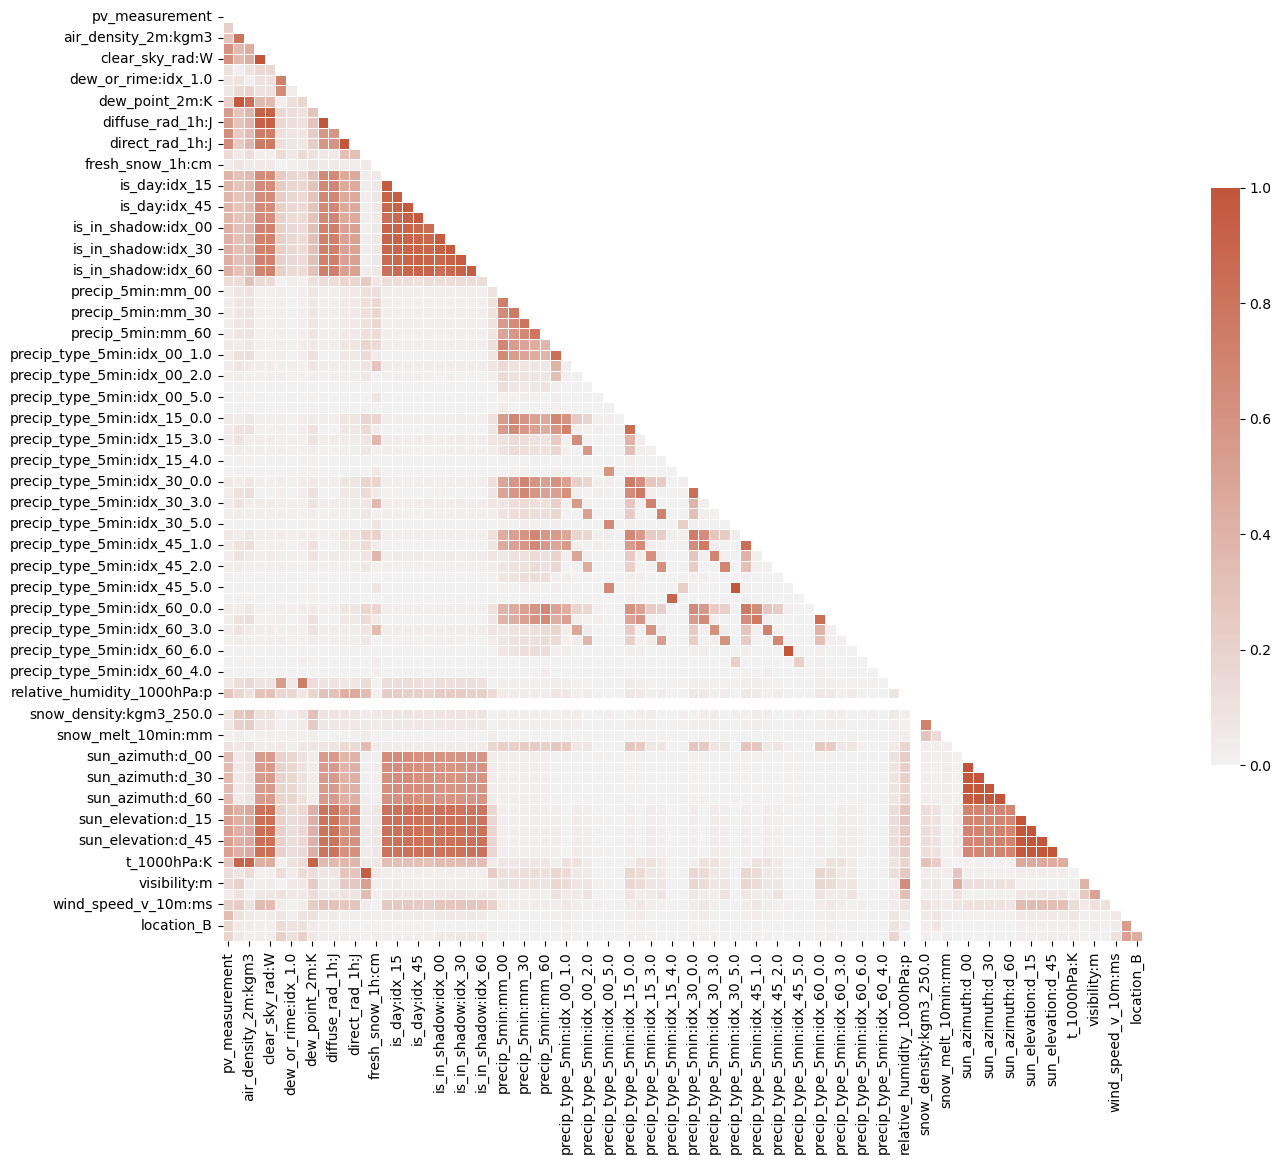

In [26]:
show_corr_matrix(dataset.drop(columns=["location", "merge_time"]))

In [27]:
dataset = dataset.sort_values(by="merge_time")

datasetX = dataset.iloc[:, 3:]
datasetY = dataset.iloc[:, 1]

display(datasetX)
display(datasetY)

,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx_0.0,dew_or_rime:idx_1.0,dew_or_rime:idx_-1.0,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,fresh_snow_1h:cm,is_day:idx_00,is_day:idx_15,is_day:idx_30,is_day:idx_45,is_day:idx_60,is_in_shadow:idx_00,is_in_shadow:idx_15,is_in_shadow:idx_30,is_in_shadow:idx_45,is_in_shadow:idx_60,msl_pressure:hPa,precip_5min:mm_00,precip_5min:mm_15,precip_5min:mm_30,precip_5min:mm_45,precip_5min:mm_60,precip_type_5min:idx_00_0.0,precip_type_5min:idx_00_1.0,precip_type_5min:idx_00_3.0,precip_type_5min:idx_00_2.0,precip_type_5min:idx_00_6.0,precip_type_5min:idx_00_5.0,precip_type_5min:idx_00_4.0,precip_type_5min:idx_15_0.0,precip_type_5min:idx_15_1.0,precip_type_5min:idx_15_3.0,precip_type_5min:idx_15_2.0,precip_type_5min:idx_15_4.0,precip_type_5min:idx_15_5.0,precip_type_5min:idx_30_0.0,precip_type_5min:idx_30_1.0,precip_type_5min:idx_30_3.0,precip_type_5min:idx_30_2.0,precip_type_5min:idx_30_5.0,precip_type_5min:idx_45_0.0,precip_type_5min:idx_45_1.0,precip_type_5min:idx_45_3.0,precip_type_5min:idx_45_2.0,precip_type_5min:idx_45_6.0,precip_type_5min:idx_45_5.0,precip_type_5min:idx_45_4.0,precip_type_5min:idx_60_0.0,precip_type_5min:idx_60_1.0,precip_type_5min:idx_60_3.0,precip_type_5min:idx_60_2.0,precip_type_5min:idx_60_6.0,precip_type_5min:idx_60_5.0,precip_type_5min:idx_60_4.0,prob_rime:p,relative_humidity_1000hPa:p,snow_density:kgm3_nan,snow_density:kgm3_250.0,snow_depth:cm,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d_00,sun_azimuth:d_15,sun_azimuth:d_30,sun_azimuth:d_45,sun_azimuth:d_60,sun_elevation:d_00,sun_elevation:d_15,sun_elevation:d_30,sun_elevation:d_45,sun_elevation:d_60,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_u_10m:ms,wind_speed_v_10m:ms,location_A,location_B,location_C
34058,2.040327,1.2400,0.0,0.0,1,0,0,4.047486,0.0,0.0,0.0,0.0,2.482278,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,3.240223,0.00,0.05,0.05,0.05,0.05,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0.0,6.253541,0,0,0.0,-0.0,0.06,1.415629,1.380111,1.334072,1.278634,1.214615,-1.926144,-1.912993,-1.895453,-1.873643,-1.847414,3.096047,2.612417,0.895646,0.431154,1.420076,0,1,0
34059,2.018069,1.2394,0.0,0.0,1,0,0,4.018223,0.0,0.0,0.0,0.0,2.837055,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,3.182279,0.05,0.00,0.00,0.00,0.00,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,6.197367,0,0,0.0,-0.0,0.10,1.214591,1.144011,1.067851,0.987255,0.902944,-1.847266,-1.817029,-1.782861,-1.744868,-1.703032,3.080719,2.906145,0.714456,0.582058,1.719039,0,1,0
34060,1.995811,1.2388,0.0,0.0,1,0,0,4.000664,0.0,0.0,0.0,0.0,2.817799,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,3.173131,0.00,0.00,0.00,0.00,0.00,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,6.122937,0,0,0.0,-0.0,0.10,0.902926,0.816387,0.728191,0.638966,0.549047,-1.702895,-1.657684,-1.609192,-1.557651,-1.503070,3.065391,2.875597,0.592284,0.790449,1.847166,0,1,0
34061,1.995811,1.2396,0.0,0.0,1,0,0,4.000660,0.0,0.0,0.0,0.0,2.827719,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,3.197528,0.00,0.06,0.06,0.06,0.06,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0.0,6.243711,0,0,0.0,-0.0,0.10,0.549036,0.459238,0.369729,0.280803,0.192570,-1.502949,-1.445838,-1.386382,-1.324782,-1.261222,2.991825,2.857974,0.350030,1.343763,1.836489,0,1,0
34062,2.129359,1.2370,0.0,0.0,1,0,0,4.135285,0.0,0.0,0.0,0.0,2.813715,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,3.240228,0.06,0.00,0.00,0.00,0.00,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,6.415040,0,0,0.0,-0.0,0.10,0.192566,0.105341,0.019222,-0.065741,-0.149388,-1.261121,-1.196019,-1.129673,-1.062286,-0.994034,3.034735,2.835063,0.339636,2.047981,0.982308,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

34058    0.0
34059    0.0
34060    0.0
34061    0.0
34062    0.0
        ... 
34056    0.0
88797    0.0
34057    0.0
62729   -0.0
88798   -0.0
Name: pv_measurement, Length: 88799, dtype: float64

In [28]:
#!ReWrite
def evaluate_models(models, X, Y):
    preds = X.iloc[:,1:2]

    for i in range(len(models)):
        preds[str(i)] = models[i].predict(X)


    preds = preds.iloc[:,1:]


    preds["final"] = preds.mean(axis=1)
    preds["losses"] = (preds["final"] - Y).apply(lambda a : np.abs(a))
    return preds["losses"].mean()

In [29]:
def get_predictions(models, X):
    preds = X.iloc[:,1:2]

    for i in range(len(models)):
        preds[str(i)] = models[i].predict(X, verbose=0)


    preds = preds.iloc[:,1:]
    return preds.mean(axis=1)

In [30]:
num_folds = 9

losses = []
models = []
for f in range(0, num_folds):
  evalIndex=f*10000
  evalSize=10000

  #partition into training and evalset
  trainsetX = pd.concat([datasetX.iloc[:evalIndex,:],datasetX.iloc[evalIndex+evalSize:,:]])
  trainsetY = pd.concat([datasetY.iloc[:evalIndex],datasetY.iloc[evalIndex+evalSize:]])
  evalsetX = datasetX.iloc[evalIndex:evalIndex+evalSize,:]
  evalsetY = datasetY.iloc[evalIndex:evalIndex+evalSize]

  numModels = 20

  models = []



  i = 0
  while(i < numModels):
    if(i < 10):
      models.append(tf.keras.models.Sequential([
            #tf.keras.layers.GaussianNoise(stddev=0.1, seed=42),
            tf.keras.layers.Dense(70, activation="tanh",
              kernel_initializer=tf.keras.initializers.RandomUniform(-1, 1),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(70, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal()),
            tf.keras.layers.Dense(1, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal()),
        ]))
    else:
      models.append(tf.keras.models.Sequential([
            #tf.keras.layers.GaussianNoise(stddev=0.1, seed=42),
            tf.keras.layers.Dense(100, activation="tanh",
              kernel_initializer=tf.keras.initializers.RandomUniform(-1, 1),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(80, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(60, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(40, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(20, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(1, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
        ]))
    models[i].compile(
        optimizer=tf.keras.optimizers.legacy.Adadelta(learning_rate=1,
                                                            #weight_decay=0.0001
                                                            ),
        loss="mean_absolute_error"
    )

    history = models[i].fit(
                        x = trainsetX.sample(frac=0.8 if i < 10 else 0.8, random_state=i),
                        y = trainsetY.sample(frac=0.8 if i < 10 else 0.8, random_state=i),
                        batch_size = 1000,
                        epochs = 1,
                        verbose = 0,
                        #validation_data = [evalsetX, evalsetY]
                    )

    #retry if model is nonsensical
    loss = models[i].evaluate(evalsetX, evalsetY, verbose=0)
    if(loss < evalsetY.mean() + 4 and loss > evalsetY.mean() - 4):
      print("discarding")
      del models[i]
      continue

    history = models[i].fit(
                        x = trainsetX.sample(frac=0.65 if i < 10 else 0.65, random_state=i),
                        y = trainsetY.sample(frac=0.65 if i < 10 else 0.65, random_state=i),
                        batch_size = 1000,
                        epochs = 40,
                        verbose = 0,
                        validation_data = [evalsetX, evalsetY]
                    )
    loss = models[i].evaluate(evalsetX, evalsetY)
    print(i, " complete")
    i+=1

  loss = evaluate_models(models, evalsetX, evalsetY)
  print(loss)
  losses.append(loss)

print(losses)


313/313 [==============================] - 0s 338us/step - loss: 117.0021
0  complete
313/313 [==============================] - 0s 352us/step - loss: 119.0698
1  complete
discarding
313/313 [==============================] - 0s 329us/step - loss: 121.9943
2  complete
313/313 [==============================] - 0s 321us/step - loss: 117.5201
3  complete
discarding
313/313 [==============================] - 0s 325us/step - loss: 118.1711
4  complete
discarding
313/313 [==============================] - 0s 320us/step - loss: 118.4851
5  complete
313/313 [==============================] - 0s 326us/step - loss: 118.0904
6  complete
discarding
313/313 [==============================] - 0s 335us/step - loss: 119.3656
7  complete
discarding
discarding
313/313 [==============================] - 0s 321us/step - loss: 118.3052
8  complete
313/313 [==============================] - 0s 330us/step - loss: 117.5299
9  complete
313/313 [==============================] - 0s 336us/step - loss: 121.1738


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 330us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 316us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 317us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 347us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 332us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 351us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 353us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 356us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 384us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 440us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 335us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 385us/step
115.40823769529925


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 332us/step - loss: 31.0013
0  complete
313/313 [==============================] - 0s 330us/step - loss: 29.8683
1  complete
313/313 [==============================] - 0s 324us/step - loss: 29.2433
2  complete
313/313 [==============================] - 0s 337us/step - loss: 29.4372
3  complete
313/313 [==============================] - 0s 410us/step - loss: 29.8643
4  complete
313/313 [==============================] - 0s 372us/step - loss: 29.2566
5  complete
313/313 [==============================] - 0s 319us/step - loss: 29.9045
6  complete
313/313 [==============================] - 0s 325us/step - loss: 29.4884
7  complete
313/313 [==============================] - 0s 335us/step - loss: 29.6733
8  complete
313/313 [==============================] - 0s 324us/step - loss: 30.2695
9  complete
discarding
313/313 [==============================] - 0s 351us/step - loss: 28.5614
10  complete
313/313 [==============================] - 0s 339us/s

/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 308us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 314us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 320us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 311us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 317us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 373us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 356us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 380us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 343us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 370us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 330us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


29.0981636651814
313/313 [==============================] - 0s 336us/step - loss: 128.6114
0  complete
discarding
313/313 [==============================] - 0s 329us/step - loss: 128.6051
1  complete
313/313 [==============================] - 0s 320us/step - loss: 128.2599
2  complete
313/313 [==============================] - 0s 324us/step - loss: 129.6893
3  complete
313/313 [==============================] - 0s 307us/step - loss: 129.2083
4  complete
313/313 [==============================] - 0s 319us/step - loss: 128.9523
5  complete
313/313 [==============================] - 0s 314us/step - loss: 128.6433
6  complete
313/313 [==============================] - 0s 336us/step - loss: 129.7645
7  complete
313/313 [==============================] - 0s 303us/step - loss: 132.9507
8  complete
313/313 [==============================] - 0s 311us/step - loss: 130.4438
9  complete
313/313 [==============================] - 0s 336us/step - loss: 129.3259
10  complete
313/313 [================

/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 307us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 311us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 307us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 308us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 308us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 306us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 308us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 318us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 310us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


123.67391769784956
discarding
313/313 [==============================] - 0s 429us/step - loss: 82.3524
0  complete
313/313 [==============================] - 0s 321us/step - loss: 83.4458
1  complete
313/313 [==============================] - 0s 319us/step - loss: 82.6939
2  complete
313/313 [==============================] - 0s 353us/step - loss: 82.5901
3  complete
313/313 [==============================] - 0s 329us/step - loss: 82.8726
4  complete
313/313 [==============================] - 0s 344us/step - loss: 81.6527
5  complete
discarding
discarding
313/313 [==============================] - 0s 327us/step - loss: 83.7523
6  complete
313/313 [==============================] - 0s 321us/step - loss: 82.5112
7  complete
313/313 [==============================] - 0s 332us/step - loss: 81.7682
8  complete
313/313 [==============================] - 0s 390us/step - loss: 80.8194
9  complete
313/313 [==============================] - 0s 339us/step - loss: 81.0032
10  complete
313/313 [===

/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 347us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 440us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 329us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 372us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 345us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 351us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 378us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 373us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 358us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 368us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 364us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 342us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 336us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 323us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


79.93403188124284
313/313 [==============================] - 0s 579us/step - loss: 75.7852
0  complete
discarding
313/313 [==============================] - 0s 333us/step - loss: 76.4329
1  complete
313/313 [==============================] - 0s 347us/step - loss: 77.2015
2  complete
discarding
313/313 [==============================] - 0s 332us/step - loss: 75.5293
3  complete
313/313 [==============================] - 0s 329us/step - loss: 76.4846
4  complete
313/313 [==============================] - 0s 477us/step - loss: 75.4531
5  complete
313/313 [==============================] - 0s 423us/step - loss: 75.9891
6  complete
313/313 [==============================] - 0s 312us/step - loss: 75.7409
7  complete
313/313 [==============================] - 0s 312us/step - loss: 75.6891
8  complete
313/313 [==============================] - 0s 359us/step - loss: 76.5626
9  complete
313/313 [==============================] - 0s 344us/step - loss: 76.7953
10  complete
313/313 [===============

/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 314us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 315us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 339us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 320us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 374us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 329us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 451us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 372us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 352us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


193/313 [=================>............] - ETA: 0s

/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 328us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


73.82445881437377
313/313 [==============================] - 0s 409us/step - loss: 121.2555
0  complete
discarding
313/313 [==============================] - 0s 344us/step - loss: 122.1767
1  complete
discarding
313/313 [==============================] - 0s 331us/step - loss: 122.6490
2  complete
discarding
313/313 [==============================] - 0s 324us/step - loss: 122.0741
3  complete
313/313 [==============================] - 0s 409us/step - loss: 121.4809
4  complete
313/313 [==============================] - 0s 363us/step - loss: 121.1162
5  complete
discarding
discarding
313/313 [==============================] - 0s 536us/step - loss: 124.0645
6  complete
313/313 [==============================] - 0s 318us/step - loss: 122.8159
7  complete
discarding
313/313 [==============================] - 0s 319us/step - loss: 122.3985
8  complete
discarding
discarding
313/313 [==============================] - 0s 328us/step - loss: 122.0461
9  complete
313/313 [=========================

/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 310us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 306us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 312us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 313us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 329us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 315us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 320us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 403us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 316us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 312us/step
118.19179610945174


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


discarding
313/313 [==============================] - 0s 313us/step - loss: 19.1325
0  complete
discarding
discarding
313/313 [==============================] - 0s 417us/step - loss: 19.8197
1  complete
313/313 [==============================] - 0s 328us/step - loss: 19.8158
2  complete
313/313 [==============================] - 0s 371us/step - loss: 19.4376
3  complete
discarding
discarding
313/313 [==============================] - 0s 330us/step - loss: 19.7525
4  complete
313/313 [==============================] - 0s 334us/step - loss: 19.6021
5  complete
discarding
313/313 [==============================] - 0s 324us/step - loss: 19.5933
6  complete
discarding
313/313 [==============================] - 0s 312us/step - loss: 19.4553
7  complete
discarding
discarding
discarding
discarding
discarding
313/313 [==============================] - 0s 334us/step - loss: 18.9620
8  complete
313/313 [==============================] - 0s 314us/step - loss: 19.6408
9  complete
discarding
discard

/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 319us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 350us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 314us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 339us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 331us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 332us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 401us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 338us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 341us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 337us/step
18.824332541820493


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 336us/step - loss: 161.2482
0  complete
313/313 [==============================] - 0s 319us/step - loss: 156.8579
1  complete
313/313 [==============================] - 0s 317us/step - loss: 160.7511
2  complete
discarding
313/313 [==============================] - 0s 328us/step - loss: 160.2637
3  complete
313/313 [==============================] - 0s 309us/step - loss: 162.0507
4  complete
313/313 [==============================] - 0s 312us/step - loss: 161.3215
5  complete
discarding
313/313 [==============================] - 0s 309us/step - loss: 162.0542
6  complete
313/313 [==============================] - 0s 309us/step - loss: 161.7034
7  complete
313/313 [==============================] - 0s 315us/step - loss: 161.7477
8  complete
313/313 [==============================] - 0s 310us/step - loss: 160.0447
9  complete
313/313 [==============================] - 0s 332us/step - loss: 157.1927
10  complete
313/313 [======================

/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 309us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 313us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 309us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 306us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 308us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 324us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 323us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 366us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 336us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


313/313 [==============================] - 0s 337us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


154.18702409398946
275/275 [==============================] - 0s 318us/step - loss: 60.5734
0  complete
275/275 [==============================] - 0s 331us/step - loss: 62.3142
1  complete
275/275 [==============================] - 0s 320us/step - loss: 61.9313
2  complete
275/275 [==============================] - 0s 320us/step - loss: 61.5588
3  complete
275/275 [==============================] - 0s 315us/step - loss: 63.8888
4  complete
275/275 [==============================] - 0s 333us/step - loss: 60.7638
5  complete
275/275 [==============================] - 0s 403us/step - loss: 62.1765
6  complete
275/275 [==============================] - 0s 398us/step - loss: 62.1249
7  complete
discarding
275/275 [==============================] - 0s 344us/step - loss: 61.5849
8  complete
275/275 [==============================] - 0s 308us/step - loss: 60.1031
9  complete
275/275 [==============================] - 0s 438us/step - loss: 62.5564
10  complete
discarding
275/275 [==============

/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


275/275 [==============================] - 0s 306us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


275/275 [==============================] - 0s 351us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


275/275 [==============================] - 0s 309us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


275/275 [==============================] - 0s 312us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


275/275 [==============================] - 0s 327us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


275/275 [==============================] - 0s 319us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


275/275 [==============================] - 0s 321us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


275/275 [==============================] - 0s 317us/step


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


275/275 [==============================] - 0s 312us/step
58.99993392826959
[115.40823769529925, 29.0981636651814, 123.67391769784956, 79.93403188124284, 73.82445881437377, 118.19179610945174, 18.824332541820493, 154.18702409398946, 58.99993392826959]


/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/1640799090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


In [32]:
preds = get_predictions(models, evalsetX)

/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/997855954.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X, verbose=0)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/997855954.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X, verbose=0)
/var/folders/_1/my8qv4fj7rx474cf5cw329lm0000gn/T/ipykernel_23709/997855954.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [33]:


comparison = dataset[["location", "merge_time", "pv_measurement"]]
comparison = comparison.iloc[80000:88802,:]
comparison["pv_pred"] = preds
comparison = comparison.rename(columns={"pv_measurement": "pv_true"})

comparisonA = comparison[comparison["location"].apply(lambda loc: loc == "A")]
comparisonB = comparison[comparison["location"].apply(lambda loc: loc == "B")]
comparisonC = comparison[comparison["location"].apply(lambda loc: loc == "C")]

display(comparison.describe())

,merge_time,pv_true,pv_pred
count,8799,8799.000000,8799.000000
mean,2023-02-20 18:11:56.399590656,186.250244,190.550812
min,2022-11-27 15:00:00,-0.000000,0.000000
25%,2023-01-18 15:00:00,0.000000,0.000000
50%,2023-02-22 01:00:00,0.000000,0.000000
75%,2023-03-31 09:00:00,48.101350,47.124830
max,2023-04-30 22:00:00,5172.640000,5024.985840
std,NaN,639.977347,633.720398


<Axes: title={'center': 'C'}, xlabel='merge_time'>

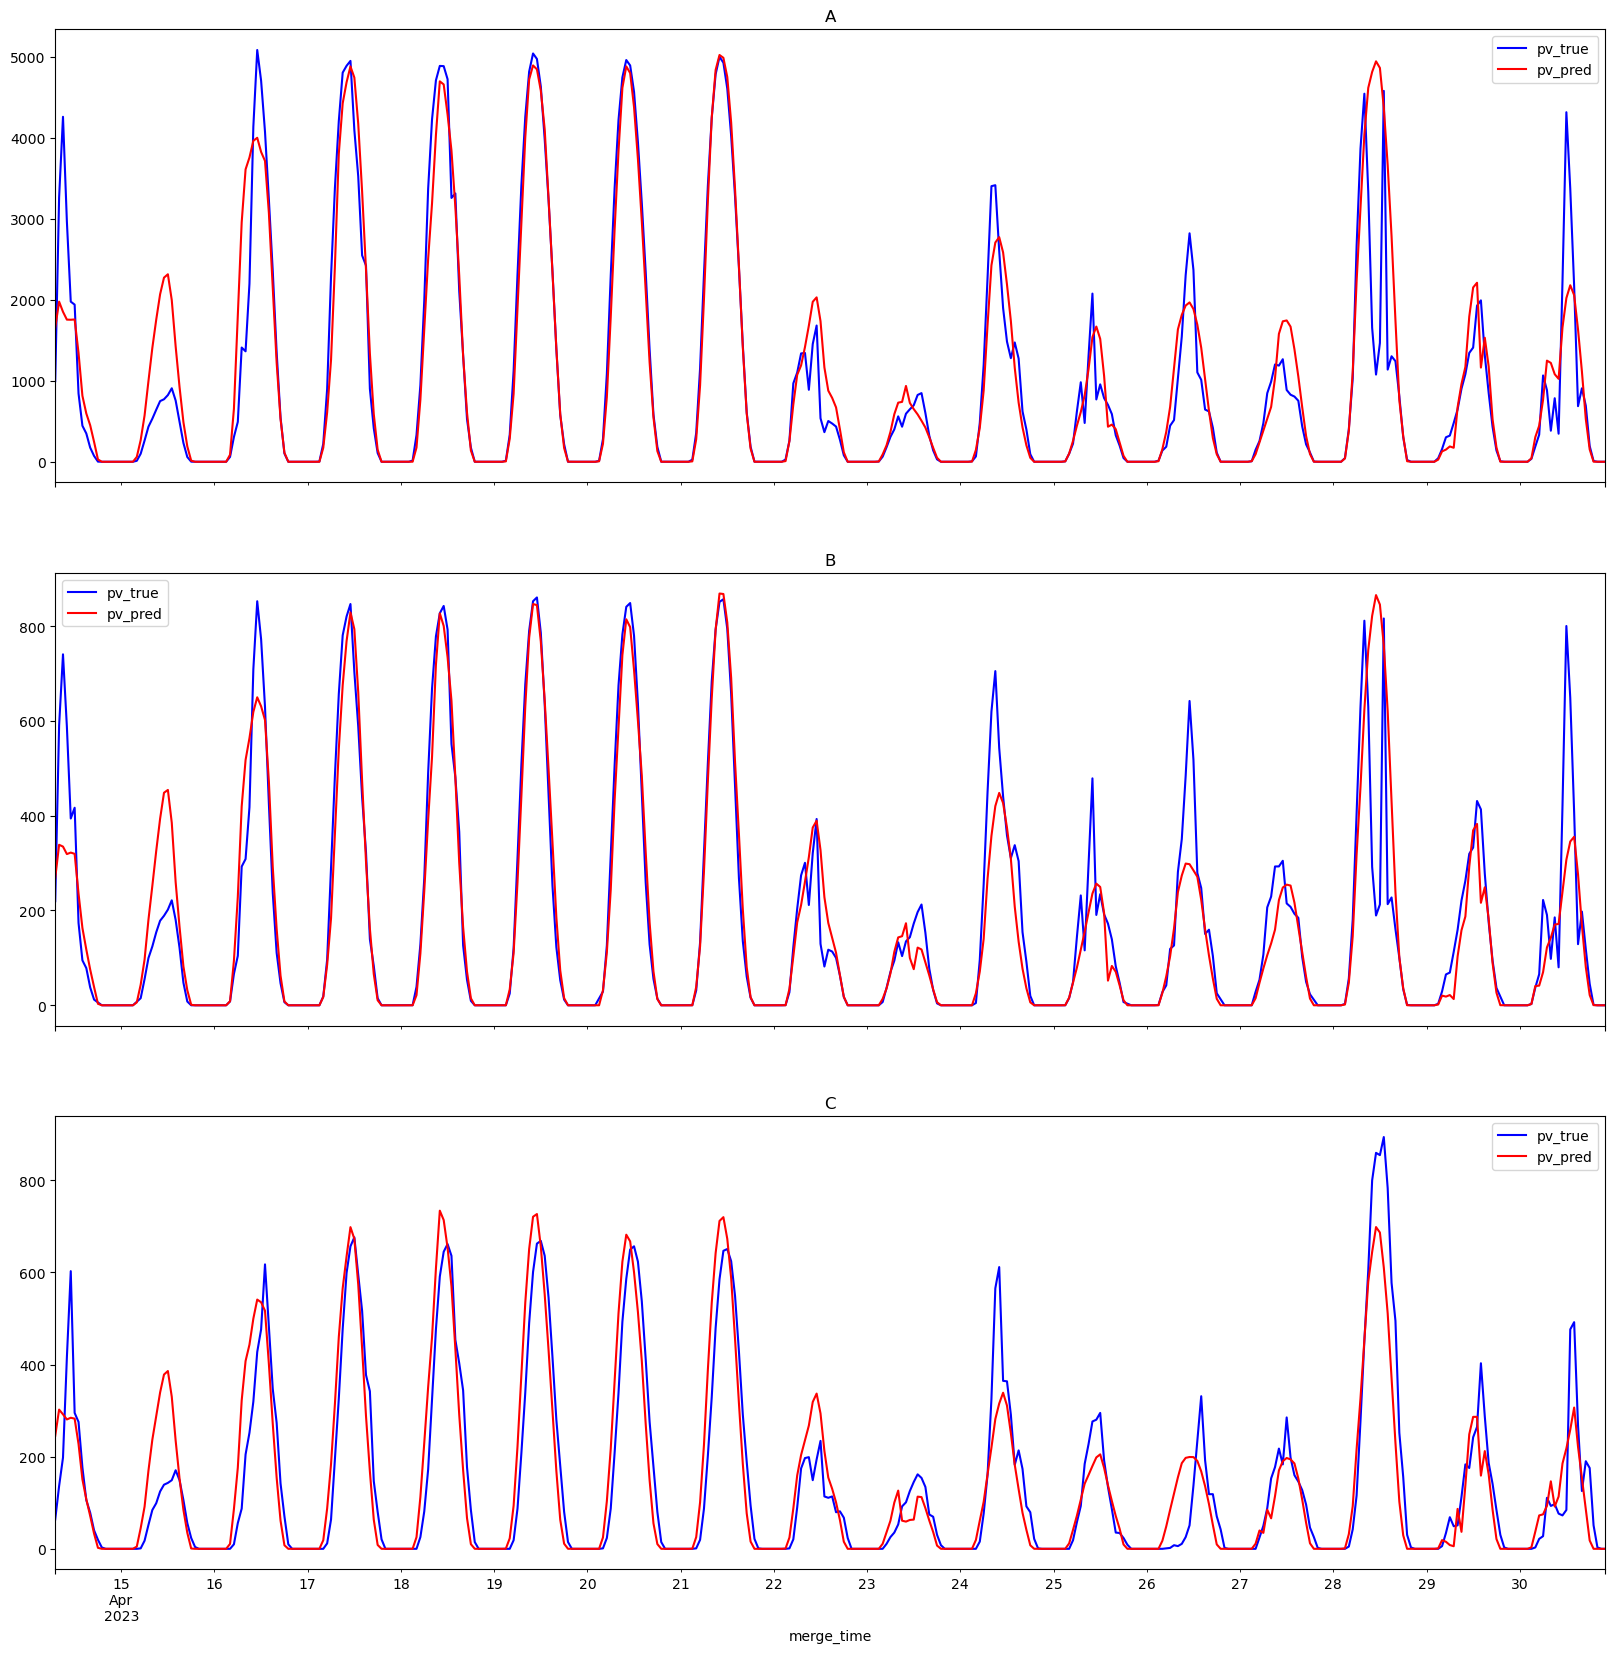

In [34]:
fig, axs = plt.subplots(3, 1, figsize=(20, 20), sharex=True)

comparisonA.iloc[-400:][['merge_time', 'pv_true']].set_index('merge_time').plot(ax=axs[0], title='A', color='blue')
comparisonA.iloc[-400:][['merge_time', "pv_pred"]].set_index('merge_time').plot(ax=axs[0], title='A', color='red')
comparisonB.iloc[-400:][['merge_time', 'pv_true']].set_index('merge_time').plot(ax=axs[1], title='B', color='blue')
comparisonB.iloc[-400:][['merge_time', "pv_pred"]].set_index('merge_time').plot(ax=axs[1], title='B', color='red')
comparisonC.iloc[-400:][['merge_time', 'pv_true']].set_index('merge_time').plot(ax=axs[2], title='C', color='blue')
comparisonC.iloc[-400:][['merge_time', "pv_pred"]].set_index('merge_time').plot(ax=axs[2], title='C', color='red')